# 과제항목 2번) 기존 이미지의 문제점 2가지

- 오브젝트의 경계선이 애매하다. 
- 오브젝트가 다른 오브젝트에 의해 누락(인식 불안정)이 될 수 있다.
- 금요일에 작업하는 코드는 불안정하다...내 코드...😥😣

(706, 1016, 3)


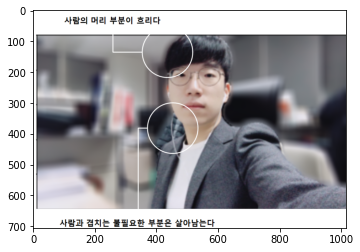

In [1]:
import cv2
import os
from matplotlib import pyplot as plt

img_orig = cv2.imread(os.getenv('HOME')+'/aiffel/human_segmentation/images/문제점.png') 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 과제 항목 3번) 해당 문제 솔루션


- 최신 모델 사용 : self-supervised learning, weakly-supervised learning 등의 학습 방법과 Transformer 기반의 모델들이 세그멘테이션 분야에서 주목을 받고 있습니다. - chatGPT

## Import

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## Image Upload

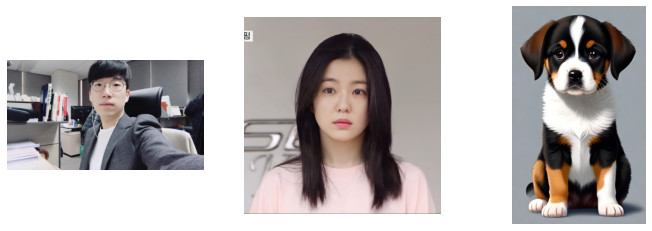

In [3]:
img_path1 = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_image.png'
img_path2 = os.getenv('HOME') + '/aiffel/human_segmentation/images/woman.jpg'
img_path3 = os.getenv('HOME') + '/aiffel/human_segmentation/images/dog.jpg'

img_paths = [img_path1, img_path2, img_path3]

fig, axes = plt.subplots(1, len(img_paths), figsize=(12, 4))
img_origs = []
for i, img_path in enumerate(img_paths):
    img_orig = cv2.imread(img_path)
    img_origs.append(img_orig)
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(img_rgb)
    axes[i].axis('off')

plt.show()


## Model

### download

In [4]:
# 모델 다운로드
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ff600b47fd0>)

### Load

In [5]:
# 모델 로드 
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

### Segmentation

In [6]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [7]:
# 세그멘테이션 라벨들
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

### 세그멘테이션 결과

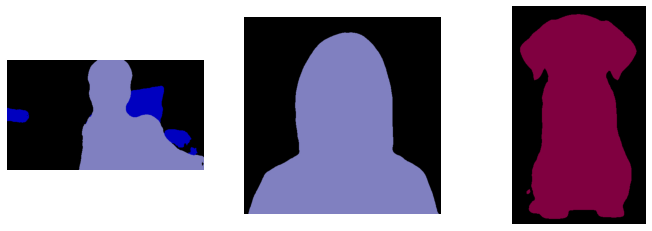

In [8]:
# 세그멘테이션 
fig, axes = plt.subplots(1, len(img_paths), figsize=(12, 4))

segvalues = []
outputs = []
for i, img_path in enumerate(img_paths):
    img_orig = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    segvalue, output = model.segmentAsPascalvoc(img_path)
    segvalues.append(segvalue)
    outputs.append(output)
    
    axes[i].imshow(output)
    axes[i].axis('off')
plt.show()

In [9]:
# 목표 색상 찾기
for idx, s in enumerate(segvalues):
    print(idx ,'번째:',end='')
    for i in s['class_ids']:
        print(LABEL_NAMES[i],colormap[i], end='/')
    print()

0 번째:background [0 0 0]/chair [192   0   0]/person [192 128 128]/
1 번째:background [0 0 0]/person [192 128 128]/
2 번째:background [0 0 0]/dog [ 64   0 128]/


In [10]:
# 타겟 찾기
people_color = (128,128,192) # RGB to BGR
dog_color = (128,0,64)
seg_maps = []
for idx, output in enumerate(outputs):
    if idx < 2 :
        seg_map = np.all(output==people_color, axis=-1)
    else:
        seg_map = np.all(output==dog_color, axis=-1)
    seg_maps.append(seg_map)

### 배경 및 오브젝트 분리

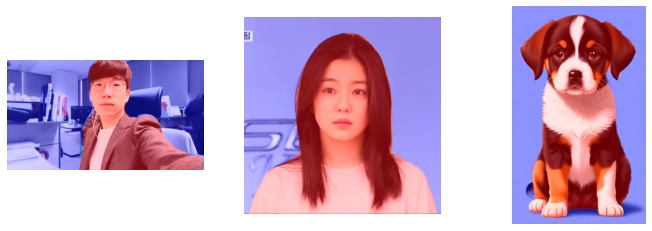

In [11]:
# 원본을 배경 + 사람 으로 나누고 합치기
fig, axes = plt.subplots(1, len(img_paths), figsize=(12, 4))
img_masks = []

for idx, img_orig in enumerate(img_origs):
    img_show = img_orig.copy()

    # 마스크 영역을 1 or 0 분리
    img_mask = seg_maps[idx].astype(np.uint8) * 255
    img_masks.append(img_mask)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    img_show = cv2.addWeighted(img_show, 0.9, color_mask, 0.8, 0.0)

    #plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img_show)
    axes[idx].axis('off')
plt.show()

### 최종) 배경 흐리게 하기

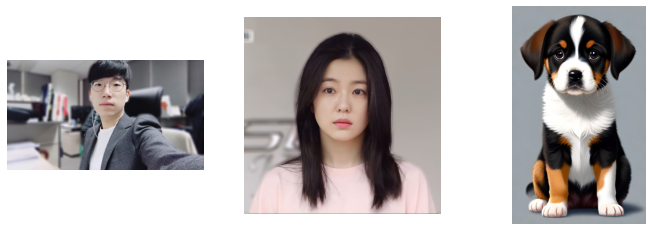

In [12]:
fig, axes = plt.subplots(1, len(img_paths), figsize=(12, 4))

for i in range(3):
    img_orig = img_origs[i]
    img_mask = img_masks[i]
    img_orig_blur = cv2.blur(img_orig, (13,13))
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    # 이미지 합치기 
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_concat)
    axes[i].axis('off')
#plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 최종 2) 반대로 흐리게 하기

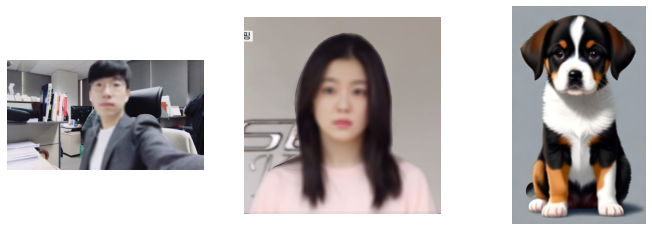

In [13]:
fig, axes = plt.subplots(1, len(img_paths), figsize=(12, 4))

for i in range(3):
    img_orig = img_origs[i]
    img_mask = img_masks[i]
    img_orig_blur = cv2.blur(img_orig, (13,13))
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    # 이미지 합치기 
    img_concat = np.where(img_mask_color==255, img_orig_blur, img_orig)
    img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_concat)
    axes[i].axis('off')
#plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 후기)

- 강아지 이미지는 생성 AI가 생성한 이미지로 blur 효과가 눈에 띄지 않는다.
- 성능은 어떻게 향상시키나요...?